In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
import numpy as np

In [0]:
import pandas as pd
import seaborn as sns
import pathlib

from sklearn.metrics import  precision_score, recall_score, f1_score, classification_report,accuracy_score,confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import sklearn
import struct
import time 
import os
import cv2

### Image Deskew

In [0]:
#deskew
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(28,28)).flatten())
    return np.array(currents)


In [0]:
def read(dataset_img, dataset_lbl=None, path = "."):

    fname_img = os.path.join(path, dataset_img)
    with open(fname_img, 'rb') as fimg:
      magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
      img = np.fromfile(fimg, dtype=np.uint8).reshape(-1, rows, cols)
    if(dataset_lbl is not None):
      fname_lbl = os.path.join(path, dataset_lbl)
      # Load everything in some numpy arrays
      with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)
        get_img = lambda idx: (lbl[idx], img[idx])
    else:
      get_img = lambda idx: (img[idx])
    # Create an iterator which returns each image in turn
    for i in range(len(img)):
      yield get_img(i)

### plot original image, dilated image, erioded image

In [0]:
tr = list(read("/gdrive/My Drive/MNIST/newtrain-images-idx3-ubyte", "/gdrive/My Drive/MNIST/newtrain-labels-idx1-ubyte")) #D1+D2+new10k = 80000
ts = list(read("/gdrive/My Drive/MNIST/mnist-new1k-images-idx3-ubyte", "/gdrive/My Drive/MNIST/mnist-new1k-labels-idx1-ubyte")) #new10k = 10000

images_train = np.array(list(zip(*tr))[1])
labels_train = np.array(list(zip(*tr))[0])

images_test = np.array(list(zip(*ts))[1])
labels_test = np.array(list(zip(*ts))[0])

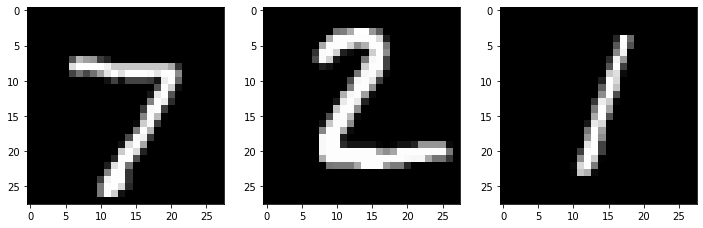

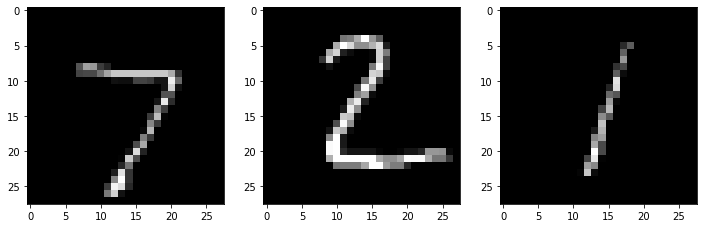

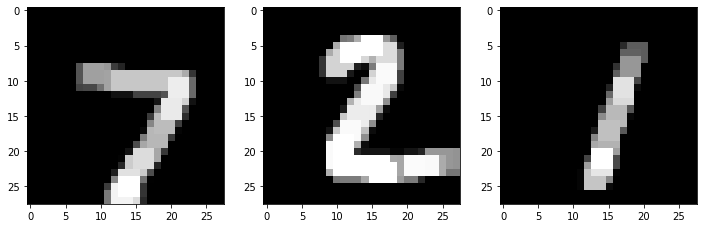

In [0]:
'''Acc doesn't imporved'''

temp_erode = images_train
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(images_train[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(images_train[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(images_train[2], cmap='gray')
plt.show()

images_train_erode = images_train
images_train_dialte = images_train

#making kernel 
kernel = np.ones((2, 2), np.uint8)
for i in range(0, len(images_train)):
  images_train_erode[i] = cv2.erode(temp_erode[i], kernel, iterations=1)   ##minimize

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(images_train_erode[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(images_train_erode[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(images_train_erode[2], cmap='gray')
plt.show()

temp_dilate = images_train
for i in range(0, len(images_train)):
  images_train_dialte[i] = cv2.dilate(temp_dilate[i], kernel, iterations=2)   ##maximize

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(images_train_dialte[0], cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(images_train_dialte[1], cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(images_train_dialte[2], cmap='gray')
plt.show()

### Standard Sclaer

In [0]:
#Standard Scaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

print(X_train_std.shape)
print(X_test_std.shape)

(70000, 784)
(10000, 784)


### Data split

In [0]:
#data split 
'''To avoid overfitting, split the train data
but, acc got better score when you just use 80,000 train data'''

tr_x, ts_x, labels_train, labels_test = train_test_split(images_train,labels_train,test_size=10000)
X_train = tr_x.reshape(-1, 28, 28)
X_test = ts_x.reshape(-1, 28, 28)

X_train_deskewed = deskewAll(X_train)
X_test_deskewed = deskewAll(X_test)
scaler = StandardScaler()
scaler.fit(X_train_deskewed)

X_train_std = scaler.transform(X_train_deskewed)
X_test_std = scaler.transform(X_test_deskewed)

### Basic Convolution

In [0]:
def convolution(image):
'''this is basic convolution method
check opencv library to make mask(kernel)
such as harrfiler, etc '''

  ori_img = image
  kernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
  input_pad = np.pad(ori_img, pad_width=1, mode='constant', constant_values=0) # padding method
  a = input_pad.shape[0]-kernel.shape[0] + 1 #(30, 3, +1)
  b = input_pad.shape[1]-kernel.shape[1] + 1 #(30, 3, +1)
  conv_result = []

  for rn in range(a):
      for cn in range(b):
          result1 = input_pad[rn:rn+kernel.shape[0],cn:cn+kernel.shape[1]] * kernel #[0:0+3,0:0+3] * kernel =  [0:3,0:3] * kernel
          conv_result.append(np.sum(result1))

  conv_img = np.array(conv_result).reshape(a,b)
  return conv_img

### SVM

In [0]:
class MySVMSGD(BaseEstimator, ClassifierMixin):
  def __init__(self, C=0.1, learning_rate=0.001, batch_size=1,max_iter=25, epsilon=1e-8,random_state=None):
    self.C = C
    self.learning_rate = learning_rate
    self.batch_size = batch_size
    self.max_iter = max_iter
    self.epsilon = epsilon
    self.random_state = random_state
    self.rgen = np.random.RandomState(self.random_state)
    
    
  def fit(self, X, y):
    self.num_classes = len(np.unique(y))
    n = np.shape(X)[1]
    self.w_ = np.random.randn(n, self.num_classes) # (784, 10)
    self.b_ = np.random.randn(1, self.num_classes)# (1, 10)

    # keep the best w
    self.min_cost = 1000
    self.best_w = self.w_
    self.best_b = self.b_

    avg_cost =0

    count = 1
    encoded_y = self.one_hot_encode(y)  #y = (80000,) y_changed = (80000, 10)
    plt_cost = []
    plt_batch = []

    for epoch in range(self.max_iter):
      X_shuffled, y_shuffled = self._shuffle(X,encoded_y) #shuffle 

      batch_count = int(np.ceil(np.shape(X)[0] / self.batch_size))

      temp_min_cost = 1000
      temp_best_w = self.w_
      temp_best_b = self.b_

      for i in range(batch_count):
        X_batch, y_batch, bs = self.next_batch(X_shuffled, y_shuffled, i)

        X_batch = np.reshape(X_batch, (bs, n))
        y_batch = np.reshape(y_batch, (bs, self.num_classes))
        val = self.net_input(X_batch)
        
        cost = self.cost_function(y_batch, val)
        self.update_weight(X_batch, y_batch, val, bs, count)


        avg_cost = avg_cost + cost
        count = count + 1

      avg_cost = avg_cost/batch_count
      temp_min_cost = avg_cost

      # see the cost value to check it actually need to keep the best w, b 
      if(epoch>150):
        plt_batch.append(epoch)
        plt_cost.append(avg_cost)

      if(self.min_cost > temp_min_cost): #before > now 
        self.min_cost = temp_min_cost
        self.best_w = temp_best_w
        self.best_b = temp_best_b

    return self

  def one_hot_encode(self, y): #one hot encoding 
    encoded_y = np.ones((np.shape(y)[0], self.num_classes))

    for i in range(self.num_classes):
      encoded_y[:,i][y != i] = -1

    return encoded_y

  def _shuffle(self, X, y = None):
    '''usde permuation rather than ramdon or other method'''

    r = self.rgen.permutation(len(y))
    return X[r], y[r]

  def net_input(self, X):
    #return(X.dot(self.w_) + self.b_)
    return(np.matmul(X,self.w_) + self.b_)
  
  def next_batch(self, X, y, i):
    '''split batchs
    use min function rather than if function '''

    number_sample_data = np.shape(X)[0]
    X_batch = X[i * self.batch_size : min(number_sample_data, (i+1) * self.batch_size)] # 0*25 ~ 1~25 = [0:24], [25,49] ... k 
    y_batch = y[i * self.batch_size : min(number_sample_data, (i+1) * self.batch_size)]
    bs = min(number_sample_data, (i + 1) * self.batch_size) - i * self.batch_size # batch size
    return X_batch, y_batch, bs

  def cost_function(self, y, val):
    '''cost function for cost value check '''

    cost_val = 1 - np.multiply(y, val)
    cost_val[cost_val < 0] = 0 
    cost = np.mean(cost_val)
    return cost

  def update_weight(self, X, y, val, bs,count):
    ''' you can use keep the best method to weight update
    but, result wasn't that much improved '''

    dw = np.zeros(self.w_.shape)
    db = np.zeros(self.b_.shape)
    val = np.reshape(val, (bs, self.num_classes))
    temp = np.multiply(y, val) #Z = before yx val
    temp = 1 - temp

    temp[temp <= 0] = 0
    temp[temp > 0] = 1 

    y_temp = np.multiply(y, temp.reshape(bs, self.num_classes))

    dw = -(1/bs) * np.matmul(X.T, y_temp) +(1/self.C) *self.w_ #don't keep the best
    db = -(1/bs) * np.sum(y_temp, axis=0) #axis 0 means sum of row val

    # self.w_ = self.best_w - (self.learning_rate/(1+self.epsilon*count)) * dw # keep best
    self.w_ = self.w_ - (self.learning_rate/(1+self.epsilon*count)) * dw # don't keep best
    # self.b_ = self.best_b - self.learning_rate * db # keep best
    self.b_ = self.b_ - self.learning_rate * db #don't keep best 

    return self.w_, self.b_

  def predict(self, X, y=None):
    c_score = self.net_input(X)
    pred_ans = np.argmax(c_score, axis=1)
    return pred_ans

  def predict_keep(self, X, y=None):
    # c_score = X.dot(self.best_w) + self.best_b
    c_score = np.matmul(X,self.best_w) + self.best_b
    pred_ans = np.argmax(c_score, axis=1)
    return pred_ans  

  def score(self, X,y=None):
    pred = self.predict(X, y)
    ans = np.mean(pred == y)
    return ans

  def score_keep(self, X, y=None):
    pred = self.predict_keep(X,y)
    ans = np.mean(pred == y)
    return ans

### Data Visualization & Feature Reduction

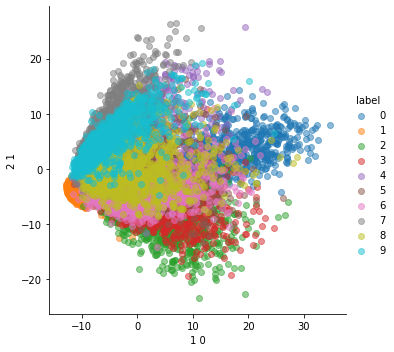

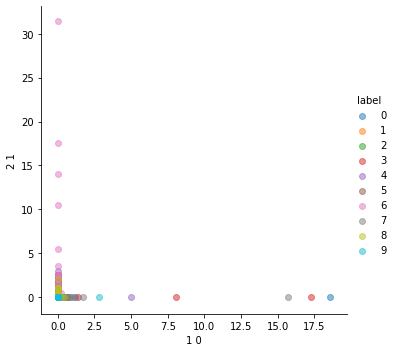

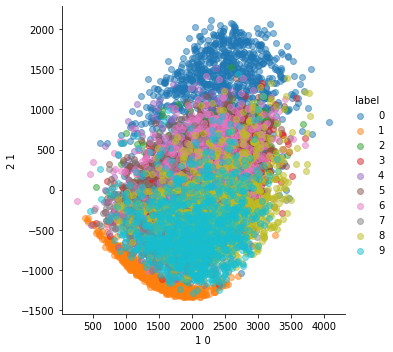

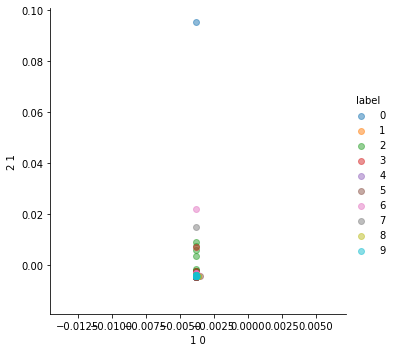

In [0]:
'''Data Visualization doesn't actually tell you the important things about data
if you uses t-sne you might see well separated datas
but it doesn't mean anything. use this just see the different of Data reduction method'''

from sklearn import datasets, cluster
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import TruncatedSVD

# X is a matrix resulting from a dimensionality reduction method such as PCA
# Y is a list of labels for each instance
# c1 and c2 are column indices corresponding to the components that we wish to plot
# N is the number of instances
def nice_scatterplot(X, Y, c1, c2, N):
    lbl1 = f'1 {c1}'
    lbl2 = f'2 {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})   

#PCA    
pca = PCA(n_components=72)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#Feature Agglomeration
agglo = cluster.FeatureAgglomeration(n_clusters=120)
agglo.fit(X_train_std)
agglo.fit(X_test_std)
X_train_agglo = agglo.transform(X_train_std)
X_test_agglo  = agglo.transform(X_test_std)

#Truncated SVD - don't use Standard Scaler
svd = TruncatedSVD(n_components=72)
X_train_SVD  = svd.fit_transform(X_train_deskewed)
X_test_SVD = svd.fit_transform(X_test_deskewed)

#Factor Analysis - don't use Standard Scaler
transformer = FactorAnalysis(n_components=5, tol=0.01, copy=True, max_iter=1000, noise_variance_init=None, svd_method='randomized', iterated_power=3, random_state=0)
X_train_FA = transformer.fit_transform(X_train_deskewed)
X_test_FA = transformer.fit_transform(X_test_deskewed)

nice_scatterplot(X_train_pca, labels_train, 0, 1, N=10000)
nice_scatterplot(X_train_agglo, labels_train, 0, 1, N=10000)
nice_scatterplot(X_train_SVD, labels_train, 0, 1, N=10000)
nice_scatterplot(X_train_FA, labels_train, 0, 1, N=10000)

### Feature Selection - Polynomial


In [0]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_pca)[:,1:]
X_test_poly = poly.fit_transform(X_test_pca)[:,1:]

SVMSGD0 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD0.fit(X_train_poly, labels_train)
print('The accuracy of the SVM using PCA&PolynomialFeatures is',SVMSGD0.score(X_test_poly,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using PCA&PolynomialFeatures is 0.9674
Time takes 55.89202833175659 


In [0]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_agglo)[:,1:]
X_test_poly = poly.fit_transform(X_test_agglo)[:,1:]

SVMSGD01 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD01.fit(X_train_poly, labels_train)
print('The accuracy of the SVM using Agglo&PolynomialFeatures is',SVMSGD01.score(X_test_poly,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using Agglo&PolynomialFeatures is 0.9399
Time takes 155.1828374862671 


In [0]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_SVD)[:,1:]
X_test_poly = poly.fit_transform(X_test_SVD)[:,1:]

SVMSGD02 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD02.fit(X_train_poly, labels_train)
print('The accuracy of the SVM using SVD&PolynomialFeatures is',SVMSGD02.score(X_test_poly,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using SVD&PolynomialFeatures is 0.6388
Time takes 55.456910371780396 


In [0]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train_FA)[:,1:]
X_test_poly = poly.fit_transform(X_test_FA)[:,1:]

SVMSGD03 = MySVMSGD(C= 1500, learning_rate=0.01, batch_size=64, max_iter=50, epsilon=1e-8, random_state=None)
start_time = time.time()
SVMSGD03.fit(X_train_poly, labels_train)
print('The accuracy of the SVM using FA&PolynomialFeatures is',SVMSGD03.score(X_test_poly,labels_test))
print('Time takes %s '% (time.time() - start_time))

The accuracy of the SVM using FA&PolynomialFeatures is 0.1092
Time takes 113.10591077804565 
